<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). [mlcourse.ai](https://mlcourse.ai) is powered by [OpenDataScience (ods.ai)](https://ods.ai/) © 2017—2022


# <center> Assignment #10. Solution <a class="tocSkip"></center> 
## <center> Implementation of the gradient boosting algorithm <a class="tocSkip"></center> 


In this assignment we go through the math and implement a gradient boosting algorithm in a rather general form: the same class will implement a binary classifier that minimizes the logistic loss function and two regressors that minimize the mean squared error (MSE) and the root mean squared logarithmic error ([RMSLE](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)). Thus, we will see that we can optimize arbitrary differentiable functions using gradient boosting, and how this technique adapts to different contexts.

### Your task is to:
 1. write code and perform computations in the cells below;
 2. choose answers in the [webform](https://forms.gle/jcn9ckFS9pXUji668).

*If you are sure that something is not 100% correct with the assignment/solution, please leave your feedback via the mentioned webform ↑*

-----


We will use the algorithm version from the [article](https://mlcourse.ai/articles/topic10-boosting/#Friedman's-classic-GBM-algorithm), but with two simplifications:
1. We initialize the algorithm with the mean value of the vector $\large y$, that is $\large \hat{f_0} = \frac{1}{n}\sum_{i=1}^{n}y_i$.
2. We make the learning rate constant: $\large \rho_t = const$.

There is a mapping between the pseudo code and the class parameters in `GradientBoosting`:

| What | Pseudo code &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;| `GradientBoosting` |
|:-----|:--------------------------------------|:-------------------|
| Training set  | $\large \{x_i, y_i\}_{i = 1,\ldots n}$ | `X`, `y` |
| Loss function | $\large L(y,f)$ | `objective` |
| Loss function gradient | $\large \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}$ | `objective_grad` |
| Number of iterations | $\large М$ | `n_estimators` |
| Base algorithm (decision tree regressor) | $\large h(x,\theta)$ | `DecisionionTreeRegressor` |
| Decision tree hyperparameters | $\large \theta$ | We will use only `max_depth` and `random_state`. |
| Learning rate<br>(coefficient for $\large h_t(x,\theta)$ in the composition) | $\large \rho_t, \quad t=1,\ldots,M$ | `learning_rate` |

## Deriving gradients for log_loss, MSE and RMSLE

Let's start with the traditional way of deriving formulas with pen and paper:
$\DeclareMathOperator{\logloss}{log\_loss}$
$\DeclareMathOperator{\MSE}{MSE}$
$\DeclareMathOperator{\RMSLE}{RMSLE}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\p}{\mathbf{p}}$

$$\begin{array}{rcl}
\logloss(\y, \p) &=& -\y\log \p + (1 - \y)\log (1 - \p) \\
&=& -\sum_{i=1}^{n}\left[y_i\log p_i + (1 - y_i)\log (1 - p_i)\right] \\
\\
\MSE(\y, \p) &=& \frac{1}{n}(\y - \p)^T(\y - \p) = \frac{1}{n}\sum_{i=1}^{n}(y_i - p_i)^2 \\
\\
\RMSLE(\y, \p) &=& \sqrt{\frac{1}{n} (\log (\p + 1) - \log (\y + 1))^T(\log (\p + 1) - \log (\y + 1))} \\
&=& \sqrt{\frac{1}{n} \sum_{i=1}^{n}(\log (p_i + 1) - \log (y_i + 1))^2}
\end{array}$$

where:

* $\y$ and $\p$ are **vectors** of values and predictions respectively.
* $\logloss$ takes the same values as in `scikit-learn`: $0$ and $1$ instead of $-1$ and $1$, as it was described in the main article.

**<font color='red'>Question 1.</font> What is the formula of the `MSE` gradient?**

$\begin{array}{rcl}
&& \text{1. } (\p - \y) && \text{3. } 2(\p - \y) \\
&& \text{2. } \frac{2}{n}(\y - \p) && \text{4. } \frac{2}{n}(\p - \y)
\end{array}$

**<font color='red'>Answer:</font>** 4.

**Solution:**

$\large \frac{\partial}{\partial p_i} \MSE = \frac{1}{n} * 2(y_i-p_i)*(-1) = \frac{2}{n}(p_i - y_i)$.

Then $\large \nabla \MSE = \frac{2}{n}(\p - \y)$.

**<font color='red'>Question 2.</font> What is the formula of the `log_loss` gradient?**

$\begin{array}{rcl}
&& \text{1. } \large \frac{\y - \p}{\y(1 - \y)} && \text{3. } \large \frac{\p - \y}{\p(1 - \p)} \\
&& \text{2. } \large \frac{\y - \p}{\p(1 - \p)} && \text{4. } \large \frac{\p - \y}{\y(1 - \y)}
\end{array}$

*Remark:* division by vector is element-wise, i.e. $\frac{1}{\p} = (\frac{1}{p_1}, \ldots \frac{1}{p_n})^T$.

**Answer:** 3.
 
**Solution:**

$\large \frac{\partial}{\partial p_i} \logloss = -\frac{y_i}{p_i} - \frac{1 - y_i}{1 - p_i}(-1) = \frac{p_i - y_i}{p_i(1 - p_i)}$.

Then $\large \nabla \logloss = \frac{\p - \y}{\p(1 - \p)}$.

**<font color='red'>Question 3.</font> What is the formula of the `RMSLE` gradient?**

$\begin{array}{rcl}
&& \text{1. } \frac{1}{n}(\p + 1)\RMSLE^{-1}(\y, \p) \log \frac{\p+1}{\y+1} && \text{3. } [n(\y + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1} \\
&& \text{2. } [n(\p + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1} && \text{4. } \frac{1}{n}\frac{\y+1}{(\p + 1)}\RMSLE^{-1}(\y, \p) \log \frac{\p+1}{\y+1}
\end{array}$

**Answer:** 2.

**Solution:**

$\frac{\partial}{\partial p_i} \RMSLE = \frac{1}{2\sqrt{\ldots}} \frac{1}{n}2(\log{(p_i+1)} - \log{(y_i+1)})\frac{1}{p_i+1} = [n(p_i + 1)\RMSLE]^{-1} \log \frac{p_i+1}{y_i+1}$

Then $\nabla \RMSLE = [n(\p + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1} $.

## Algorithm implementation

### Task:

Implement the `GradientBoosting` class using the following specification:
- The class inherits from `sklearn.base.BaseEstimator`.
- The constructor has the following parameters:

     - `loss` – a loss function to be optimized: `log_loss`, `mse` (by default) or `rmsle`;
     - `n_estimators` – the number of trees, that is the number of boosting iterations (10 by default);
     - `learning_rate` – the learning rate ($10^{-2}$ by default);
     - `max_depth` – the maximum depth of a tree (3 by default);
     - `random_state` – the seed for the random number generator, used only for trees (17 by default).
     
- Depending on the value of `loss`, `objective` and `objective_grad` are initialized differently:

     - For `mse` use `sklearn.metrics.mean_squared_error`;
     - For `log_loss` use `sklearn.metrics.log_loss`;
     - For `rmsle` you will need to implement the loss function by yourself as well as the gradients of all three loss functions. Also, don't leave out constants like $2$ or $n$ while computing the gradients.
     
- You will be using element-wise vector division in the implementations of the gradients for `log_loss` and `rmsle`. In order to avoid division by zero, first replace all values less than $10^{-5}$ for $10^{-5}$, but do it only where it is really neccesary. For example, when computing $\frac{y}{p}$, make the replacement only for the vector $p$.
- The constructor must create lists `loss_by_iter_` and `residuals_by_iter_` for debugging purposes and `trees_` for storing trained trees.
- The class must have methods `fit`, `predict` and `predict_proba`:
    - The method `fit` takes a matrix `X` and a vector `y` (both are instances of `numpy.array`) as arguments, and returns the current instance of `GradientBoosting`, i.e `self`. This method will implement the main logic of the algorithm. At each iteration, the current value of the loss function is stored in `loss_by_iter`, the value of the anti gradient (what we called *pseudo residuals* in the article) is stored in `residuals_by_iter_`. Optionally, you could add a flag `debug=False` to the constructor arguments and store the anti gradient values only when it is on. Also, you must store each new trained tree in the `trees_` list.
    - The method `predict_proba` returns a linear combination of predictions over all the trees. Also, don't forget about the initial approximation. In the case of regression, the name of the method is somewhat misleading, but let's keep it so that we don't have to implement both the regressor and classifier. In the case of classification, apply $\sigma$-transformation to the returned value. In the impementation of the $\sigma$-function replace arguments with absolute values bigger than $100$ for $100$ or $-100$ depending on the sign of the argument, to prevent underflow or overflow.
    - In the case of regression, method `predict` returns a linear combination of predictions over all the trees (plus the initial aproximation), i.e. the same as the method `predict_proba`. In the case of classification, `predict` uses `predict_proba` and returns a vector composed of $0$'s and $1$'s obtained by comparing the predicted probabilities with a threshold that maximizes a share of correct answers on the training set. Here, it would be instructive to solve a one-dimensional optimization problem, but, for the sake of reproducibility, you should choose the threshold from `np.linspace(0.01, 1.01, 100)`.

### Solution:

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from tqdm import tqdm_notebook

sns.set()
sns.color_palette("viridis")
# sharper plots
%config InlineBackend.figure_format = 'retina'

In [2]:
class GradientBoosting(BaseEstimator):
    def __init__(
        self,
        n_estimators=10,
        learning_rate=0.01,
        max_depth=3,
        random_state=17,
        loss_name="mse",
        debug=False,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.loss_name = loss_name
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0], 1])
        self.debug = debug

        if loss_name == "log_loss":
            self.objective = self.log_loss
            self.objective_grad = self.log_loss_grad
        elif loss_name == "mse":
            self.objective = mean_squared_error
            self.objective_grad = self.mse_grad
        elif loss_name == "rmsle":
            self.objective = self.rmsle
            self.objective_grad = self.rmsle_grad
        elif loss_name == "rmspe":
            self.objective = rmspe
            self.objective_grad = self.rmspe_grad

        self.trees_ = []
        self.loss_by_iter = []

        if self.debug:
            self.residuals = []
            self.temp_pred = []

    def sigma(self, z):
        z = z.reshape([z.shape[0], 1])
        z[z > 100] = 100
        z[z < -100] = -100
        return 1.0 / (1 + np.exp(-z))

    def log_loss(self, y, p):
        return log_loss(y, p, normalize=False)

    def log_loss_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        p[p < 1e-5] = 1e-5
        p[p > 1 - 1e-5] = 1 - 1e-5
        return (p - y) / p / (1 - p)

    def mse_grad(self, y, p):
        return 2 * (p - y.reshape([y.shape[0], 1])) / y.shape[0]

    def rmsle(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return np.mean(np.log((p + 1) / (y + 1)) ** 2) ** 0.5

    def rmsle_grad(self, y, p):
        y = y.reshape([y.shape[0], 1])
        p = p.reshape([p.shape[0], 1])
        return (
            1.0 / (y.shape[0] * (p + 1) * self.rmsle(y, p)) * np.log((p + 1) / (y + 1))
        )

    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)

        prediction = b.copy()

        for t in range(self.n_estimators):

            resid = -self.objective_grad(y, prediction)

            # In order to get insights about the algorithm on toy examples (debug=True),
            # we will track residuals (anti gradient) at each iteration.
            if self.debug:
                self.residuals.append(resid)

            # Train a regression tree on the residuals.
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth, random_state=self.random_state
            )
            tree.fit(X, resid)

            b = tree.predict(X).reshape([X.shape[0], 1])

            # For debugging purposes, we will save the prediction at each iteration.
            if self.debug:
                self.temp_pred.append(b)

            self.trees_.append(tree)

            prediction += self.learning_rate * b

            self.loss_by_iter.append(self.objective(y, prediction))

        # Save the prediction on the train set.
        self.train_pred = prediction

        # For the case of log_loss, apply the sigma transformation to get back to probabilities,
        # that is the estimates of the positive class classification
        if self.loss_name == "log_loss":
            self.train_pred = self.sigma(self.train_pred)

        return self

    def predict_proba(self, X):

        # At first, our prediction is just the average of respones.
        pred = np.ones([X.shape[0], 1]) * np.mean(self.y)

        # Add the predictions of the trees.
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape(
                [X.shape[0], 1]
            )

        # In the case of log_loss, apply the sigmoid function to get back to probabilities.
        if self.loss_name == "log_loss":
            return self.sigma(pred)
        else:
            return pred

    def predict(self, X):

        pred_probs = self.predict_proba(X)

        # In the case of classification, to predict a binary class (label),
        # we will choose the threshold that yields the maximum accuracy.
        if self.loss_name == "log_loss":
            max_accuracy = 0
            best_thres = 0
            for thres in np.linspace(0.01, 1.01, 100):
                acc = accuracy_score(self.y, self.train_pred > thres)
                if acc > max_accuracy:
                    max_accuracy = acc
                    best_thres = thres
            return pred_probs > best_thres
        else:
            # This solution is not perfect: in the case of regression,
            # `predict` will call `predict_proba` and return the same value.
            # We do it so as not to implement the classifier and regressor as separate classes.
            # Though, we could derive both of these classes from `GradientBoosting`.
            return pred_probs

Let's also define a couple of helper functions that we will use later:

In [3]:
def get_1d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    return np.arange(x_min, x_max, eps)


def get_2d_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps))

## Regression with a toy example

Prepare the dataset:

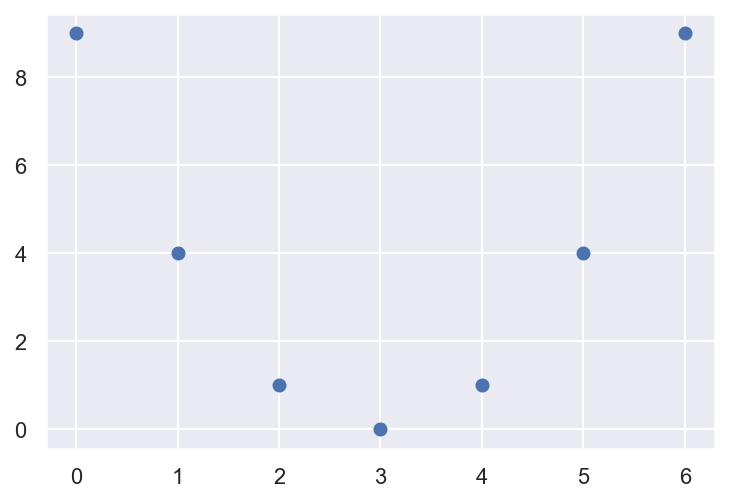

In [4]:
X_regr_toy = np.arange(7).reshape(-1, 1)

y_regr_toy = ((X_regr_toy - 3) ** 2).astype("float64")

plt.scatter(X_regr_toy, y_regr_toy);

### Task:

Train an instance of the `GradientBoosting` regressor with the loss function `MSE` and the following input parameters: `learning_rate=0.1`, `max_depth=3`, `n_estimators=200`. Then, plot the change of the loss function over boosting iterations. You could also visualize the initial approximation and pseudo residuals on the first iterations, just as it was done in the article.

### Solution:

In [5]:
boost_regr_mse = GradientBoosting(
    n_estimators=200, loss_name="mse", max_depth=3, learning_rate=0.1, debug=True
)
boost_regr_mse.fit(X_regr_toy, y_regr_toy);

#### Ultimate prediction of the ensemble

There is a problem with regression trees (consequently, with random forests and boosting as well): they can not extrapolate, only interpolate. Hence, in our case the prediction beyond the range $[0,6]$ will be constant:

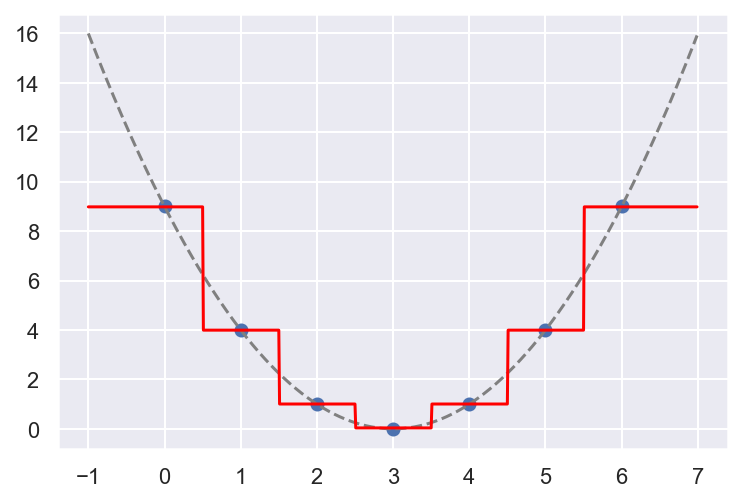

In [6]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
plt.scatter(X_regr_toy, y_regr_toy)
plt.plot(xx, boost_regr_mse.predict(xx.reshape([xx.shape[0], 1])), color="red");

#### Residuals at each iteration and the corresponding tree prediction

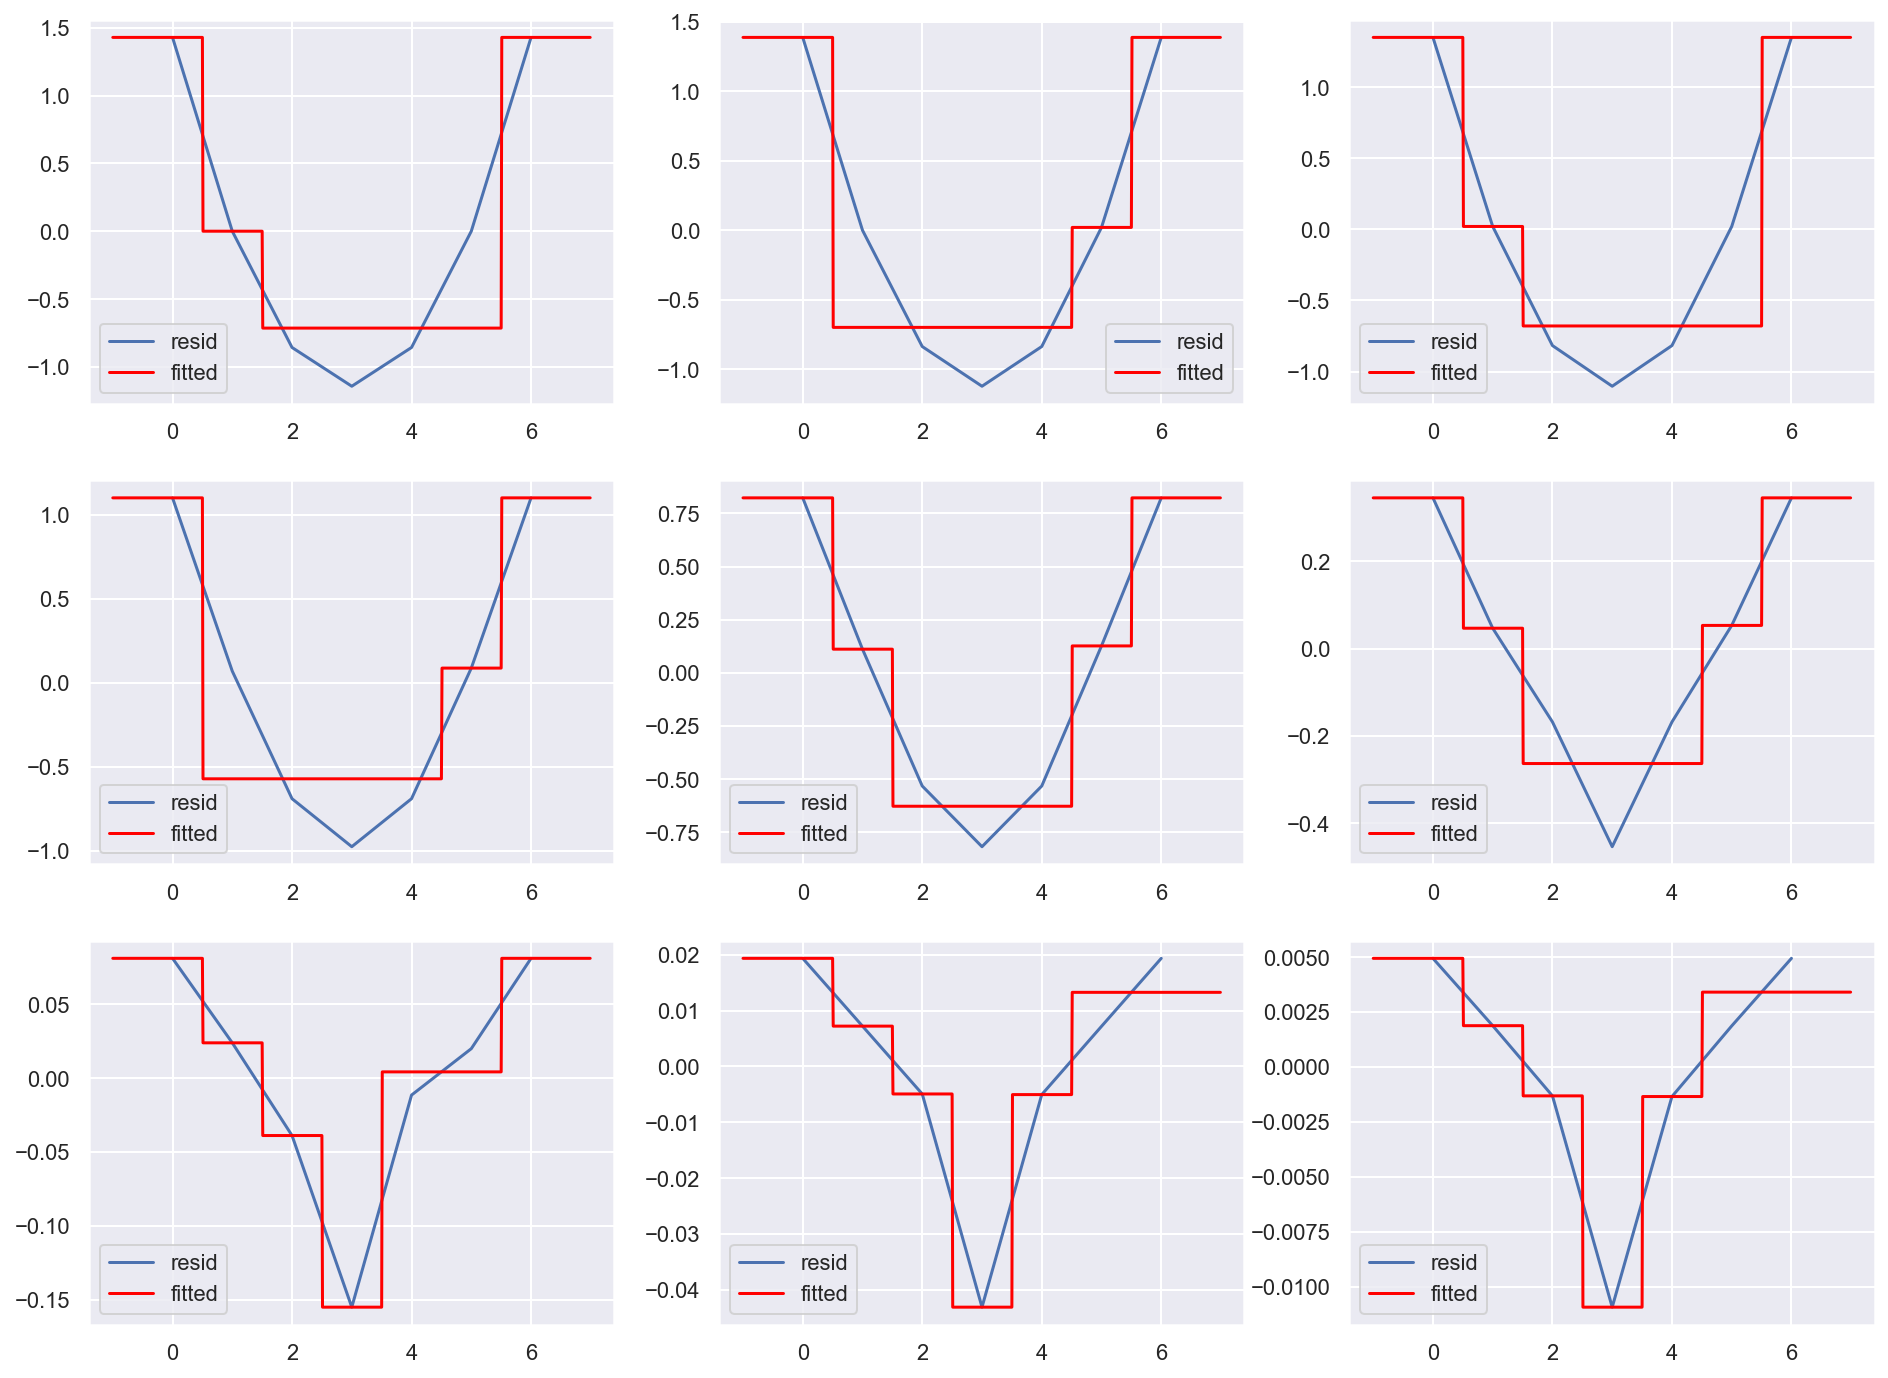

In [7]:
plt.rcParams["figure.figsize"] = (16, 12)

plt.subplots(3, 3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(X_regr_toy, boost_regr_mse.residuals[tree_idx - 1], label="resid")
    plt.plot(
        xx,
        boost_regr_mse.trees_[tree_idx - 1].predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend();

#### How an increase in the number of trees affects the whole ensemble's prediction

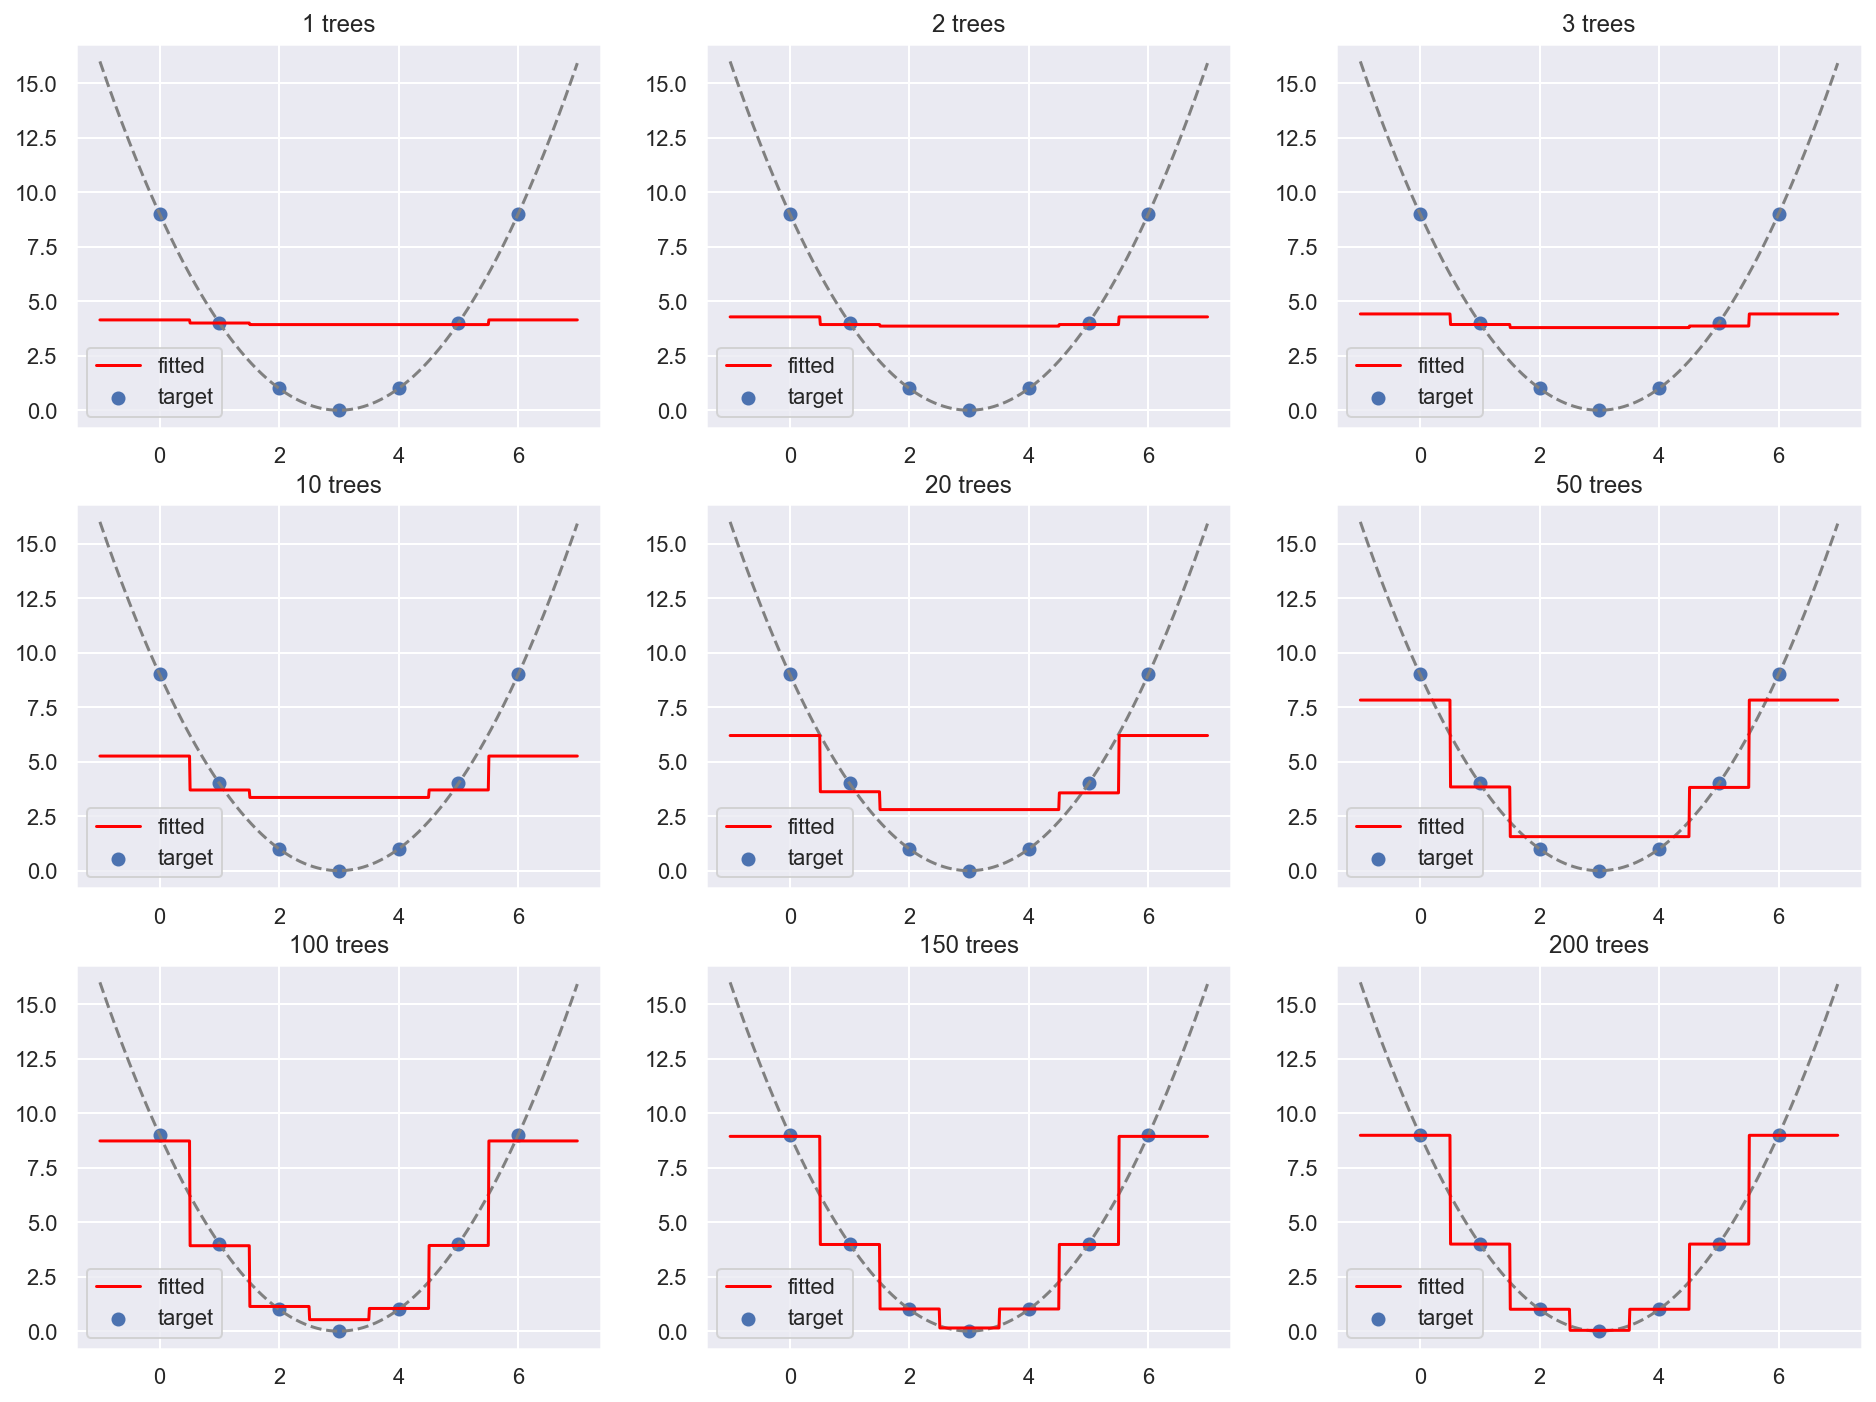

In [8]:
plt.subplots(3, 3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)

    boost_regr = GradientBoosting(
        n_estimators=n_trees,
        loss_name="mse",
        max_depth=3,
        learning_rate=0.1,
        debug=True,
    )
    boost_regr.fit(X_regr_toy, y_regr_toy)

    plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
    plt.scatter(X_regr_toy, y_regr_toy, label="target")
    plt.plot(
        xx,
        boost_regr.predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend()
    plt.title("%s trees" % str(n_trees));

#### MSE decrease over boosting iterations

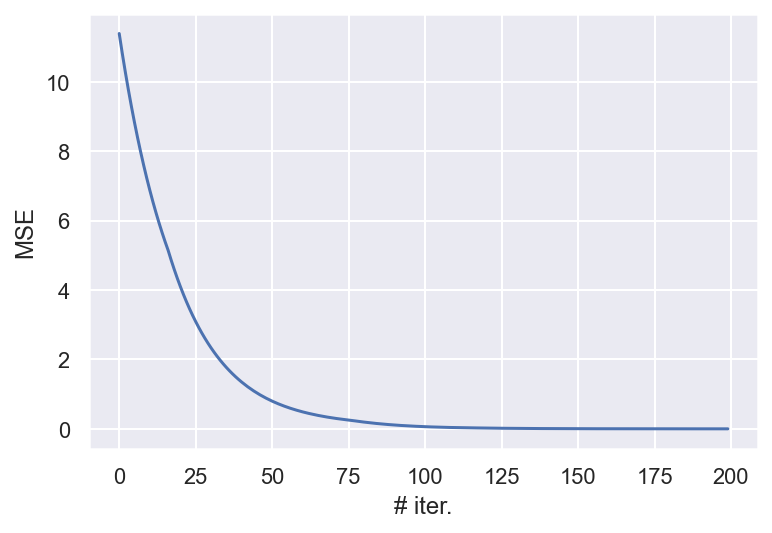

In [9]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(range(len(boost_regr_mse.loss_by_iter)), boost_regr_mse.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("MSE");

### Task:

Train another `GradientBoosting` regressor with the same input parameters but with the loss function changed to `RMSLE`. Plot the same values as in the previous task.

### Solution:

In [10]:
boost_regr_rmsle = GradientBoosting(
    n_estimators=200, loss_name="rmsle", max_depth=3, learning_rate=0.5, debug=True
)
boost_regr_rmsle.fit(X_regr_toy, y_regr_toy);

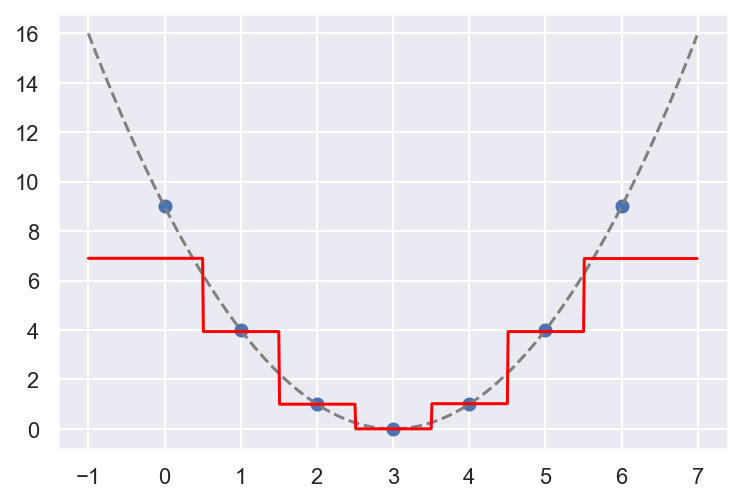

In [11]:
xx = get_1d_grid(X_regr_toy)
plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
plt.scatter(X_regr_toy, y_regr_toy)
plt.plot(xx, boost_regr_rmsle.predict(xx.reshape([xx.shape[0], 1])), color="red");

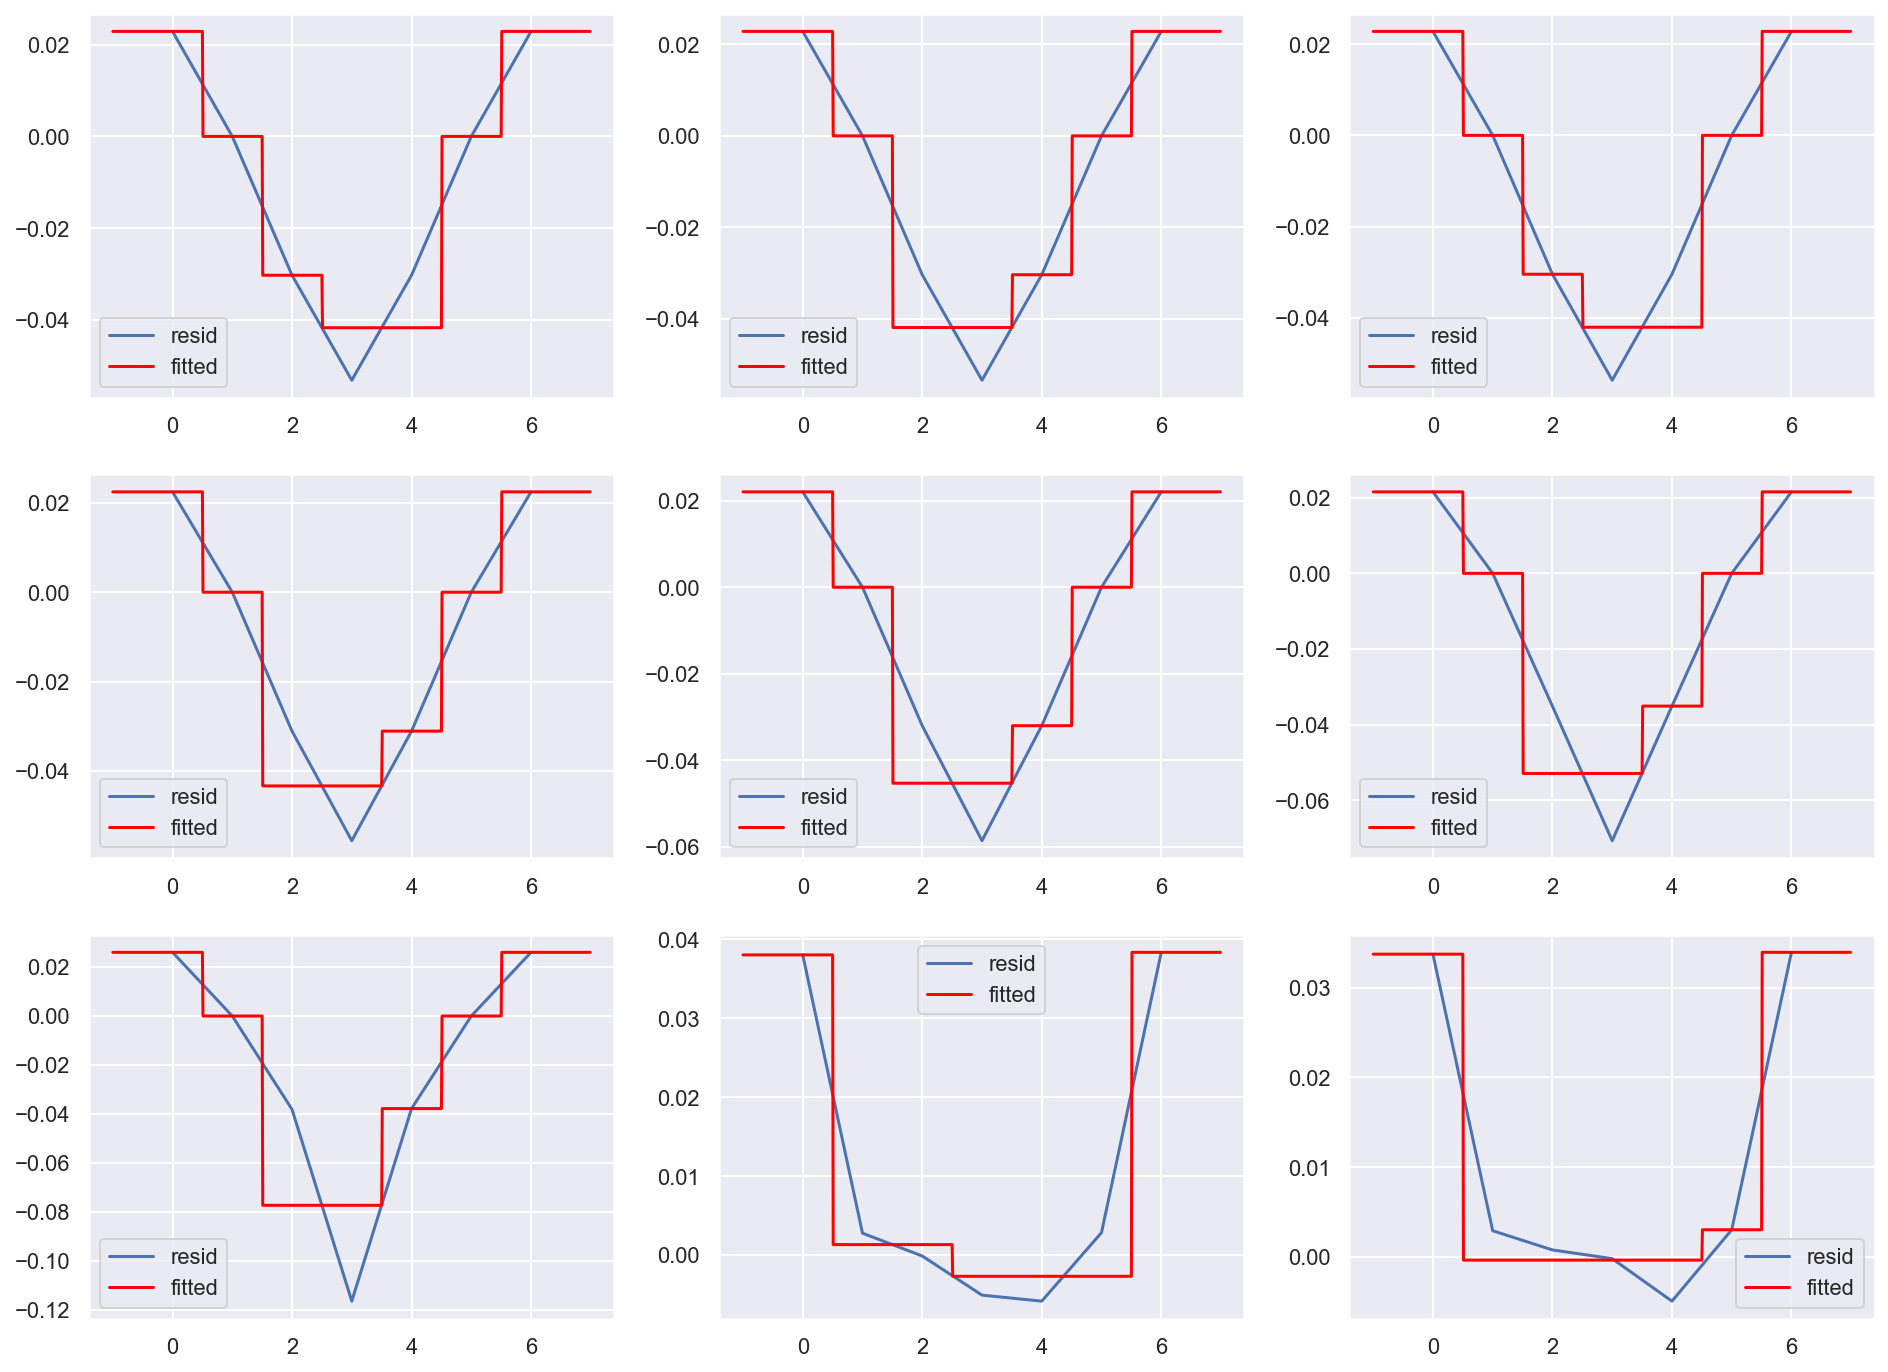

In [12]:
plt.rcParams["figure.figsize"] = (16, 12)

plt.subplots(3, 3)

for i, tree_idx in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)
    plt.plot(X_regr_toy, boost_regr_rmsle.residuals[tree_idx - 1], label="resid")
    plt.plot(
        xx,
        boost_regr_rmsle.trees_[tree_idx - 1].predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend();

#### How an increase in the number of trees affects the whole ensemble's prediction

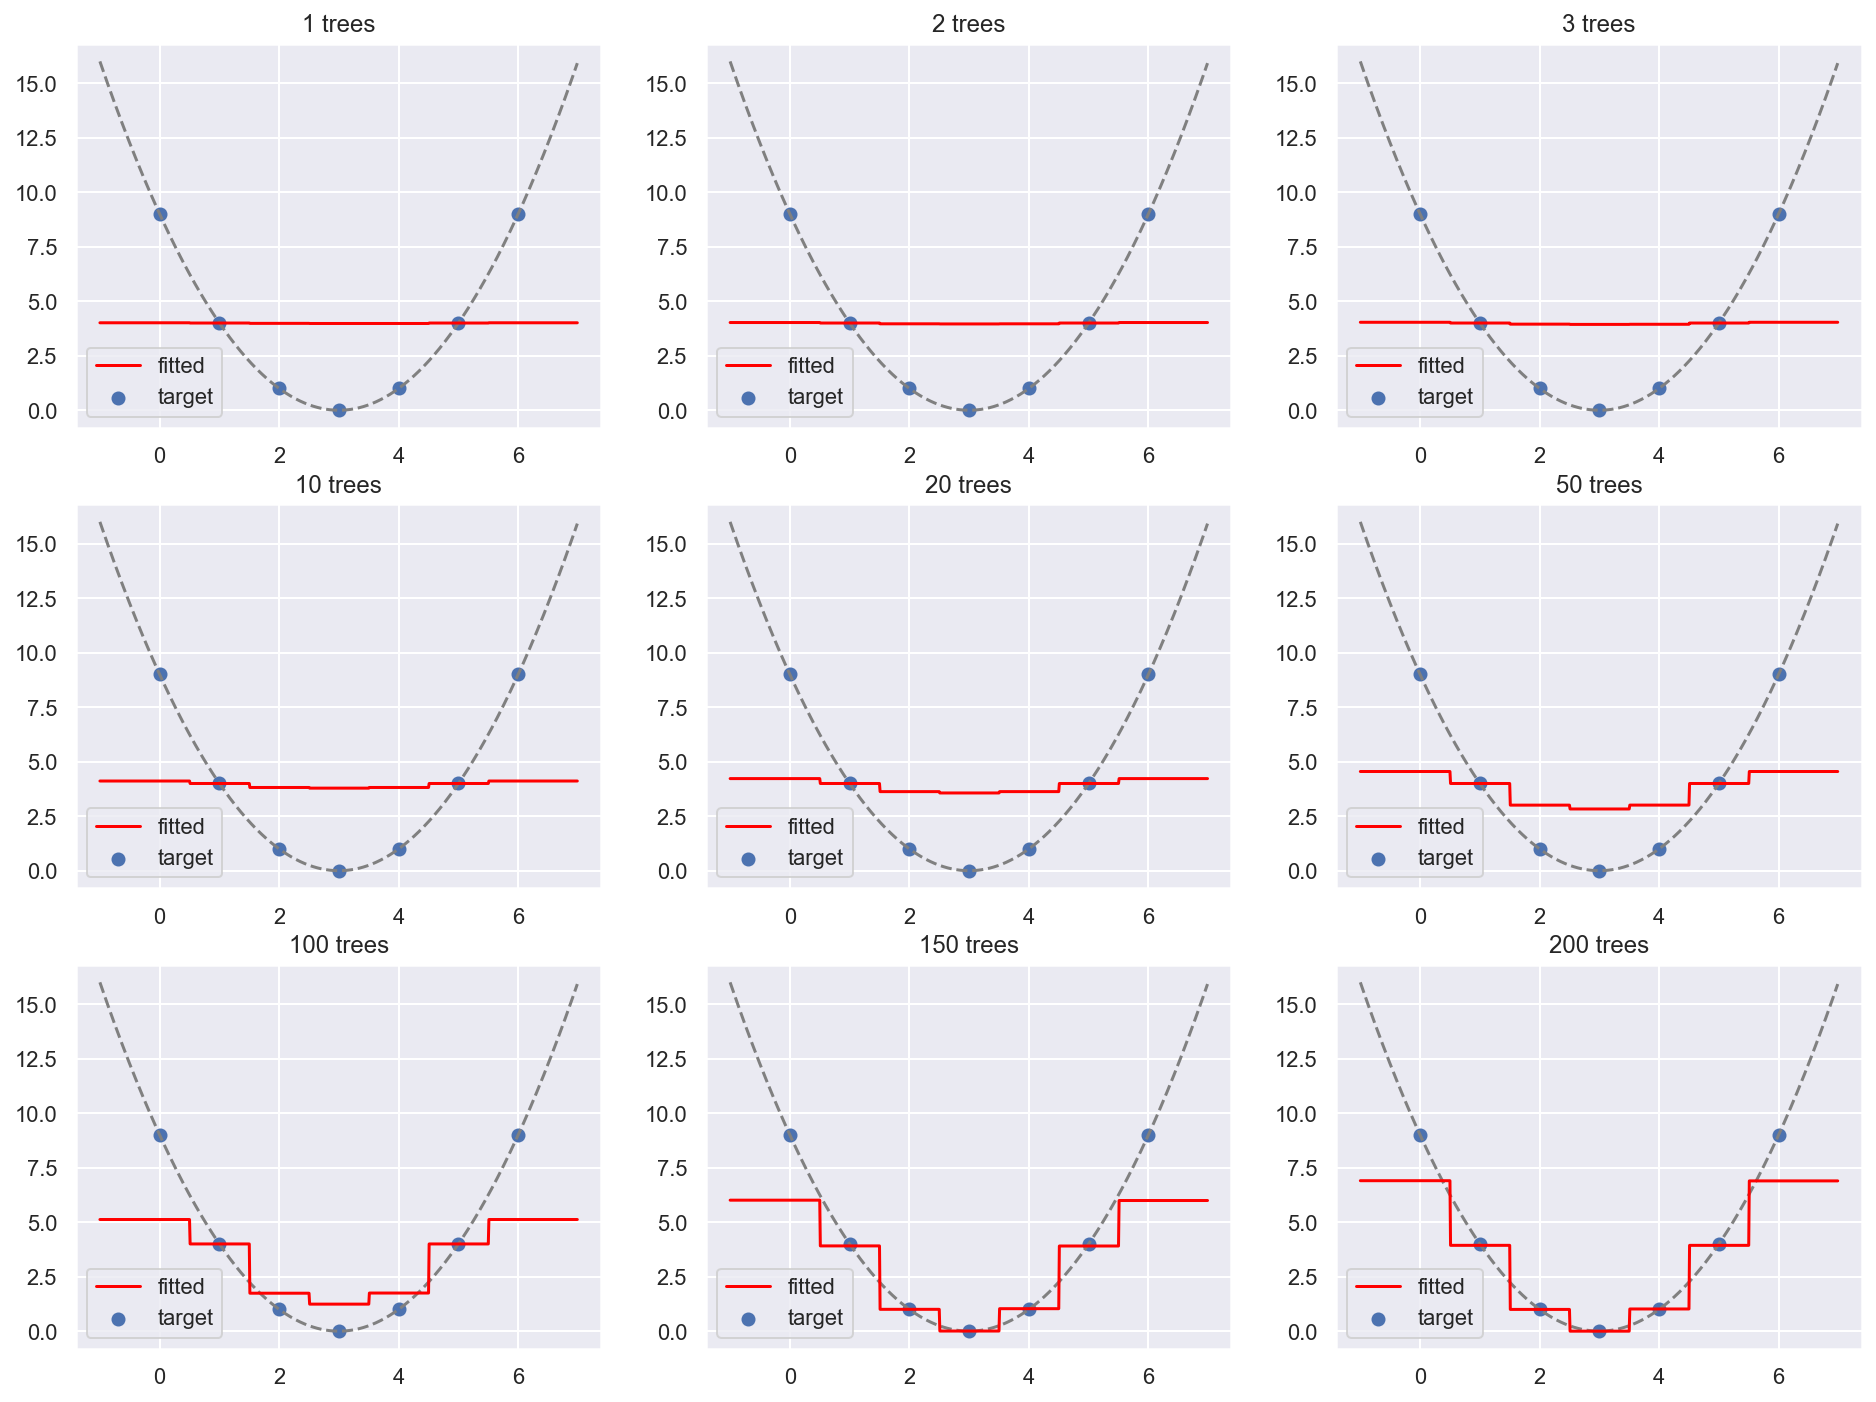

In [13]:
plt.subplots(3, 3)

for i, n_trees in enumerate([1, 2, 3, 10, 20, 50, 100, 150, 200], 1):
    plt.subplot(3, 3, i)

    boost_regr = GradientBoosting(
        n_estimators=n_trees, loss_name="rmsle", max_depth=3, learning_rate=0.5
    )
    boost_regr.fit(X_regr_toy, y_regr_toy)

    plt.plot(xx, ((xx - 3) ** 2), color="gray", linestyle="--")
    plt.scatter(X_regr_toy, y_regr_toy, label="target")
    plt.plot(
        xx,
        boost_regr.predict(xx.reshape([xx.shape[0], 1])),
        color="red",
        label="fitted",
    )
    plt.legend()
    plt.title("%s trees" % str(n_trees));

#### RMSLE decrease over boosting iterations

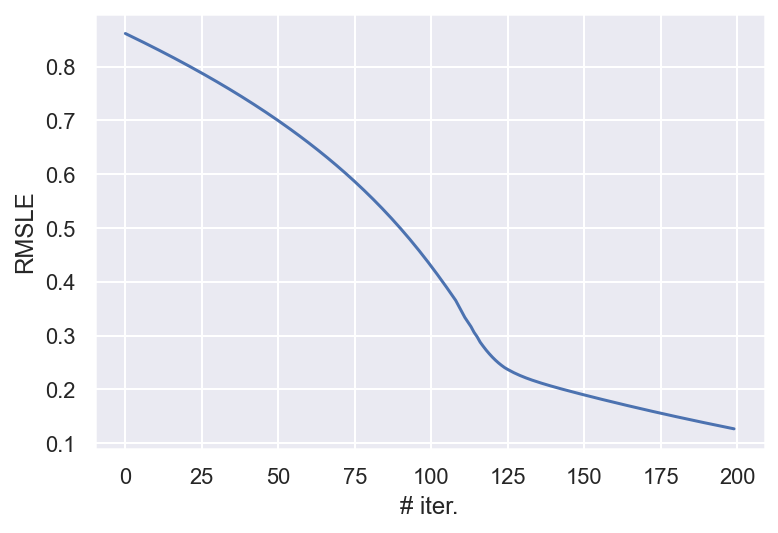

In [14]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(range(len(boost_regr_rmsle.loss_by_iter)), boost_regr_rmsle.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("RMSLE");

## Classification with a toy example

Prepare the dataset:

In [15]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0])

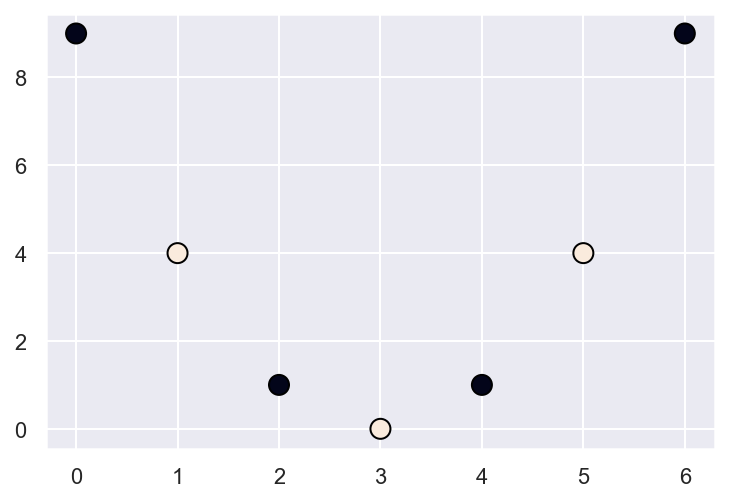

In [16]:
plt.scatter(
    X_clf_toy[:, 0],
    X_clf_toy[:, 1],
    c=y_clf_toy,
    s=100,
    edgecolors="black",
    linewidth=1,
);

### Task:

Train a classifier of type `GradientBoosting` with the loss function `log_loss` and the following parameters: `learning_rate=0.05`, `max_depth=3`, `n_estimators=10`. Then, plot the change of the loss function over boosting iterations. You could also visualize the initial approximation and pseudo residuals on the first iterations, just as it was done in the article.

### Solution:

In [17]:
boost_clf = GradientBoosting(
    n_estimators=10, loss_name="log_loss", max_depth=3, learning_rate=0.05
)
boost_clf.fit(X_clf_toy, y_clf_toy)

GradientBoosting(learning_rate=0.05, loss_name='log_loss')

In [18]:
clf_pred_probs = boost_clf.predict_proba(X_clf_toy)

#### Ultimate prediction of the ensemble

Unfortunately, this example turned out to be rather dull.

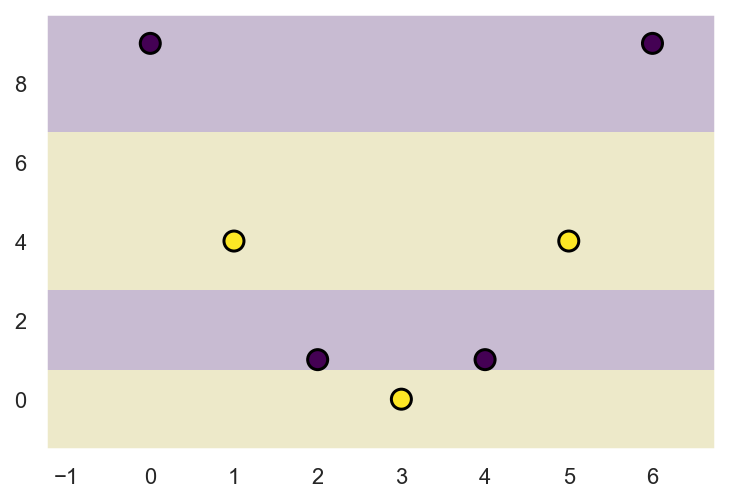

In [19]:
xx, yy = get_2d_grid(X_clf_toy, eps=0.5)
predicted = boost_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="viridis", alpha=0.2, shading="auto")
plt.scatter(
    X_clf_toy[:, 0],
    X_clf_toy[:, 1],
    c=y_clf_toy,
    s=100,
    cmap="viridis",
    edgecolors="black",
    linewidth=1.5,
);

In this case, there is no need to plot the separating surface at each iteration because the change is not perceptible.

Lets take two examples: the leftmost (purple, class 0) and the second from the left (yellow, class 1). For these examples, let's look at how the probability of classifying as class $+$ changing with an increase in the number of trees.

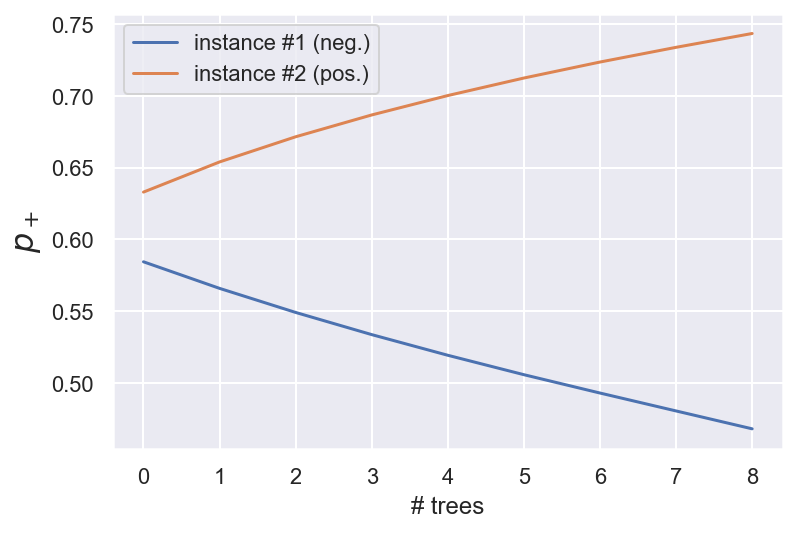

In [20]:
plt.rcParams["figure.figsize"] = (6, 4)

pred_probs1_by_tree, pred_probs2_by_tree = [], []

for i in range(9):
    boost_clf_ = GradientBoosting(
        n_estimators=i + 1, loss_name="log_loss", max_depth=3, learning_rate=0.05
    ).fit(X_clf_toy, y_clf_toy)
    pred_probs1_by_tree.append(boost_clf_.predict_proba(X_clf_toy)[0])
    pred_probs2_by_tree.append(boost_clf_.predict_proba(X_clf_toy)[1])
plt.plot(pred_probs1_by_tree, label="instance #1 (neg.)")
plt.plot(pred_probs2_by_tree, label="instance #2 (pos.)")
plt.xlabel("# trees")
plt.ylabel(r"$p_+$", fontsize=16)
plt.legend();

#### `log_loss` decrease over boosting iterations

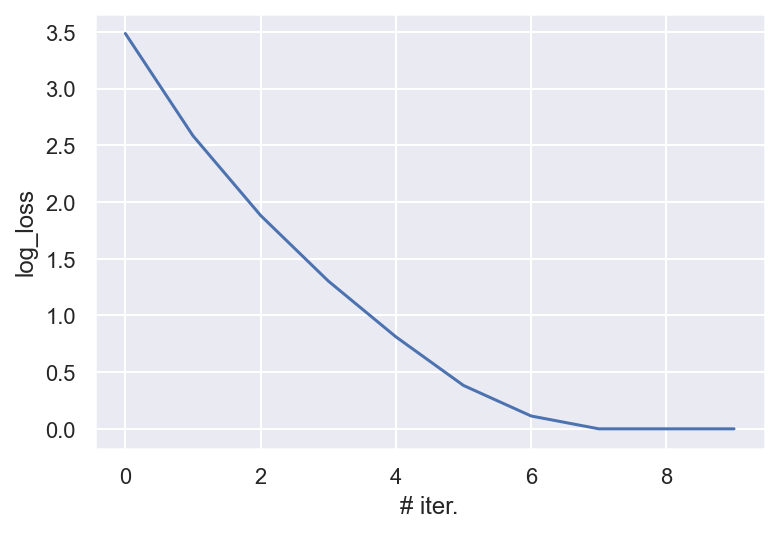

In [21]:
plt.plot(range(len(boost_clf.loss_by_iter)), boost_clf.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("log_loss");

**<font color='red'>Question 4.</font> For all $7$ examples in the toy dataset, calculate the predicted probabilities of being attributed to class $+1$? What are the two unique values in the computed vector?**

1. $0.42$ and $0.77$
2. $0.36$ and $0.82$
3. $0.48$ and $0.53$
4. $0.46$ and $0.75$

**Answer:** 4.

**Solution:**

In [22]:
clf_pred_probs

array([[0.45554883],
       [0.75303888],
       [0.45554883],
       [0.75303888],
       [0.45554883],
       [0.75303888],
       [0.45554883]])

## Regression with the Boston House-Prices Dataset

Prepare the dataset:

In [23]:
boston = load_boston()
X, y = boston.data, boston.target

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

### Task:

- Train a `GradientBoosting` regressor with the loss function `MSE` and the following parameters: `learning_rate=3`,  `max_depth=10`, `n_estimators=300`.
- Plot the change of the loss function over boosting iterations.
- Make predictions on the test set.
- Plot the distribution of `y_test` that is the output variable values from the training set, along with the distribution of `test_pred`, which contains the values predicted by gradient boosting. Use the method `hist` from `matplotlib.pyplot` with the parameter `bins=15`.

### Solution:

In [25]:
regr = GradientBoosting(
    n_estimators=300, loss_name="mse", max_depth=10, learning_rate=3
)
regr.fit(X_train, y_train)

GradientBoosting(learning_rate=3, max_depth=10, n_estimators=300)

#### MSE decrease over boosting iterations

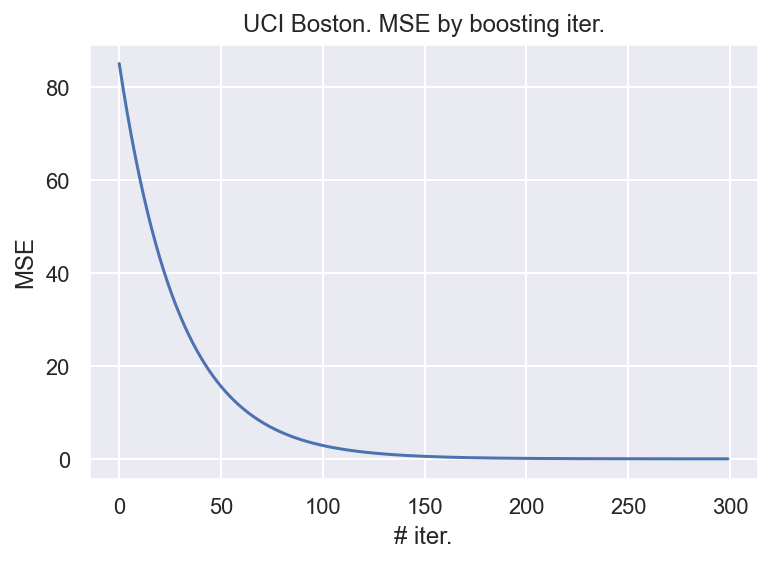

In [26]:
plt.plot(range(len(regr.loss_by_iter)), regr.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("MSE")
plt.title("UCI Boston. MSE by boosting iter.");

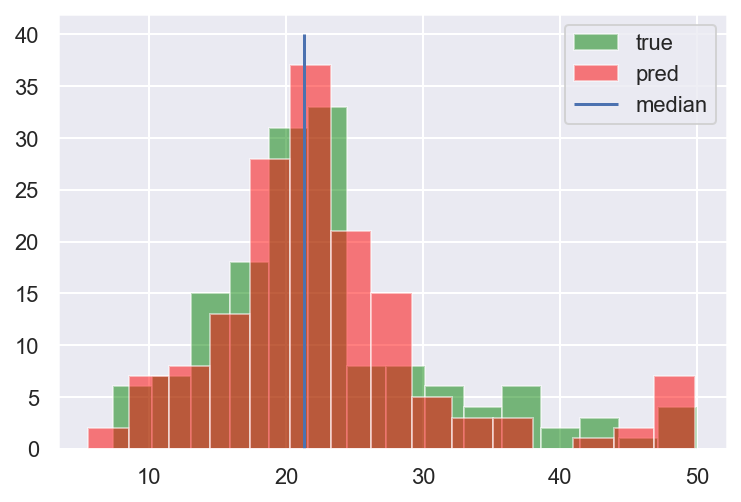

In [27]:
plt.hist(y_test, alpha=0.5, color="green", label="true", bins=15)
plt.hist(regr.predict(X_test), alpha=0.5, color="red", label="pred", bins=15)
plt.vlines(x=np.median(y_test), ymin=0, ymax=40, label="median")
plt.legend();

**<font color='red'>Question 5.</font> Choose the correct statement about the resulting histograms:**
1. On average, boosting predictions are overestimated by 10.
2. In that bin that contains the median of the answers on the test set (i.e. `numpy.median(y_test)`), there are more values from the vector of predictions `test_pred` than from the vector of answers `y_test`.
3. Sometimes our boosting algorithm predicts values that are far beyond the range of the `y_test` vector.

**Answer:** 2.

## Classification with the Breast Cancer Wisconsin Dataset

Prepare the dataset:

In [28]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17
)

### Task:

- Train a `GradientBoosting` classifier with the loss function `log_loss` and the parameters `learning_rate=0.01`, `max_depth=3`, `n_estimators=200`.
- Plot the change of the loss function over boosting iterations.
- Make predictions on the test set: both the probabilities of being in the class $+1$ and binary predictions. 
- Calculate ROC AUC for the case of probabilites and the share of correct answers for binary predictions.

### Solution:

In [30]:
clf = GradientBoosting(
    n_estimators=200, loss_name="log_loss", max_depth=3, learning_rate=0.01
)
clf.fit(X_train, y_train)

GradientBoosting(loss_name='log_loss', n_estimators=200)

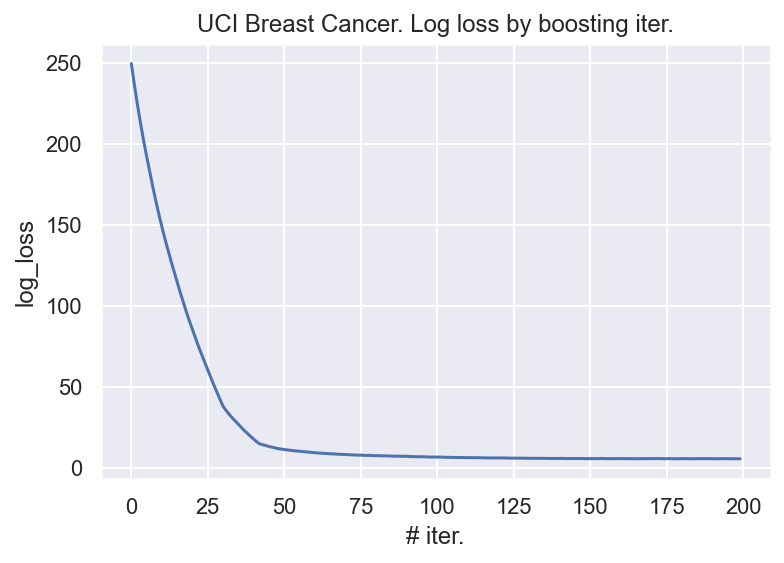

In [31]:
plt.plot(range(len(clf.loss_by_iter)), clf.loss_by_iter)
plt.xlabel("# iter.")
plt.ylabel("log_loss")
plt.title("UCI Breast Cancer. Log loss by boosting iter.");

In [32]:
pred_probs = clf.predict_proba(X_train)

#### Histograms of the predicted probabilities to belong to class $+$ for positive and negative examples

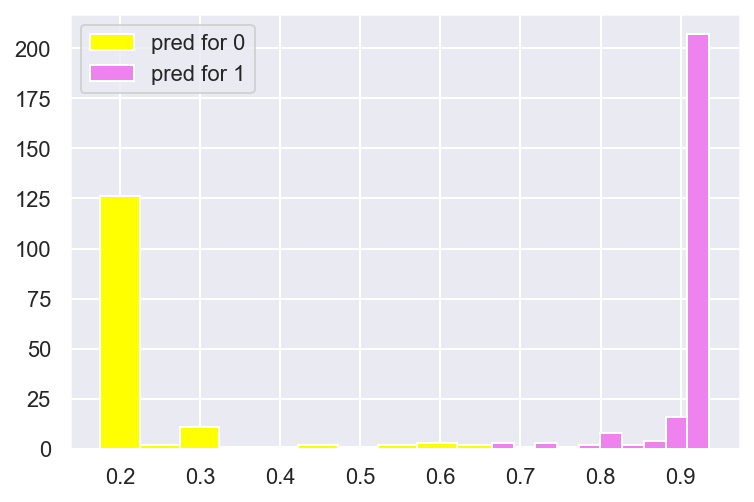

In [33]:
plt.hist(pred_probs[y_train == 0], color="yellow", label="pred for 0")
plt.hist(pred_probs[y_train == 1], color="violet", label="pred for 1")
plt.legend();

#### ROC AUC and the share of correct answers on the test set

In [34]:
roc_auc_score(y_test, clf.predict_proba(X_test)), accuracy_score(
    y_test, clf.predict(X_test)
)

(0.9885245901639345, 0.9707602339181286)

**<font color='red'>Question 6.</font> What are the ROC AUC value and the share of correct predictions on the test set `(X_test, y_test)`?**
1. $0.99$ and $0.97$
2. $1$ and $0.97$
3. $0.98$ and $0.96$
4. $0.97$ and $0.95$

**Answer:** 1.